In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import math
import statistics
import random

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
def var_threshold_selection(data, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def load_data(path):
    """
    Loads the csv or csv.gz file into a pandas df, providing unique ID.
    """
    df = pd.read_csv(path)
    
    # Seperate data and metadata
    metadata_cols = [i for i in df.columns if 'Metadata' in i]
    metadata = df[metadata_cols]
    data_cols = [i for i in df.columns if i not in metadata_cols]
    
    # Remove exclude features from the data df
    data_cols = [x for x in data_cols if x.find('Costes')<0 if x.find('Manders')<0 if x.find('RWC')<0]
    data = df[data_cols]
    
    # Use metadata to create the index
    metadata_df = metadata.copy()
    data_df = data.copy()
    metadata_df['my_id'] = metadata['Metadata_line_source'] + '_' + metadata['Metadata_line_condition'] + '_' + \
        metadata['Metadata_line_ID'].astype(str) + '_' + metadata['Metadata_well_position']
    data_df['my_id'] = metadata_df['my_id']
    data_df.set_index('my_id', inplace=True)
    print('df shape: {}'.format(data_df.shape))
    
#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
    new_idx = data_df.index.tolist()
    new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
               if 'genic' in i else i for i in new_idx]
    
    data_df.index = new_idx
    return data_df

# Create regressed STEM data

In [3]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

norm_all_features = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
data_cols = pd.read_csv(base_dir + '/3.analysis/feature_sets/STEM01/0621_stdev_corr_fs.csv', index_col=0).columns

data = norm_all_features[data_cols]
cell_counts = norm_all_features['Cells_Number_Object_Number']

df shape: (384, 4023)


In [5]:
data_residuals = data.copy()
cell_count_corrs = pd.DataFrame()
features = data.columns.tolist()

# For every feature, get the linear regression and replace value with the residual
for feature in features:
    reg = LinearRegression().fit(data[feature].values.reshape(-1,1), cell_counts.values.reshape(-1,1))
    rscore = reg.score(data[feature].values.reshape(-1,1), cell_counts.values.reshape(-1,1))
    cell_count_corrs.loc[feature, 'r-squared'] = rscore
    cell_count_corrs.loc[feature, 'slope'] = reg.coef_
    cell_count_corrs.loc[feature, 'intercept'] = reg.intercept_
    
    # Find predicted feature value based on cell count
    predicted = reg.predict(data[feature].values.reshape(-1,1)).flatten()
    residuals = data[feature].values - predicted
    data_residuals[feature] = residuals

In [7]:
# cell_count_corrs.sort_values(by='r-squared', ascending=False).head(10)

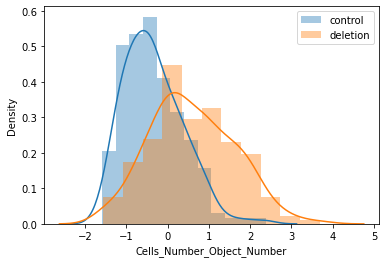

In [8]:
# Distribution of Cell counts vs control or deletion

temp = norm_all_features.copy()
temp['group'] = temp.index.str.split('_').map(lambda x: x[1])
temp = temp[['group', 'Cells_Number_Object_Number']]

sns.distplot(temp[temp['group']=='control']['Cells_Number_Object_Number'], label='control')
sns.distplot(temp[temp['group']=='deletion']['Cells_Number_Object_Number'], label='deletion')
plt.legend()
plt.show()

# Logistic Regression on residuals data

In [10]:
# RANDOM SPLIT SKLEARN

# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = True
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]
    
residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
residuals_100_trials_random_split = pd.DataFrame(columns=['x_train', 'x_test', 'y_train', 'y_test', 'train_acc', 'test_acc'])    
for i in range(100):
    residuals_xtrain, residuals_xtest, residuals_ytrain, residuals_ytest = train_test_split(residuals.drop(['label'], axis=1), residuals['label'], 
                                                                    test_size=0.3, random_state=i)
#     print(len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest))
    logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
#     print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))
    residuals_100_trials_random_split.loc[len(residuals_100_trials_random_split.index)] = \
        [len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest), 
         logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest)]

In [17]:
residuals_100_trials_random_split.std()

x_train      0.000000
x_test       0.000000
y_train      0.000000
y_test       0.000000
train_acc    0.000000
test_acc     0.015548
dtype: float64

In [12]:
# SPLIT BASED ON CELL LINE

# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = True
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]


residuals_100_trials_patient_split = pd.DataFrame(columns=['x_train', 'x_test', 'y_train', 'y_test', 'train_acc', 'test_acc'])    
for i in range(100):
    random.seed(i)
    residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
    residuals['patient_num'] = residuals.index.str.split('_').map(lambda x: x[2])

    patients = list(set(residuals['patient_num']))
    split_cut = math.ceil(0.7 * len(patients))

    random.shuffle(patients)
    train_nums = patients[0:split_cut]
    test_nums = patients[split_cut:]

    train_df = residuals[residuals['patient_num'].isin(train_nums)]
    test_df = residuals[residuals['patient_num'].isin(test_nums)]

    residuals_xtrain = train_df.drop(['label', 'patient_num'], axis=1)
    residuals_ytrain = train_df['label']
    residuals_xtest = test_df.drop(['label', 'patient_num'], axis=1)
    residuals_ytest = test_df['label']
#     print(len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest))

    logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
#     print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))
    residuals_100_trials_patient_split.loc[len(residuals_100_trials_patient_split.index)] = \
        [len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest), 
         logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest)]

In [22]:
residuals_100_trials_patient_split.std()

x_train      0.000000
x_test       0.000000
y_train      0.000000
y_test       0.000000
train_acc    0.000000
test_acc     0.062082
dtype: float64